In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from resnet50_get_relu_outputs import resnet_output
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
import plotly
from glob import glob

In [2]:
#RAN THIS COMMAND FOR SKULLSTRIPPING AND I AM PROUD OF IT!!!
#for i in *.nii; do echo $i; bet $i ${i::-4}_skullstripped.nii -R -f 0.8; done

In [23]:
# Custom Dataset class to handle loading of images
class ImageDataset(Dataset):
    # def __init__(self, folder, subs):
    #     self.data = []
    #     for sub in subs:
    #         sessions = sorted([ses for ses in os.listdir(f"{folder}/{sub}/") if "ses-" in ses])
    #         for ses in sessions:
    #             image_list = sorted(os.listdir(f"{folder}/{sub}/{ses}/axial"))
    #             for img_name in image_list:
    #                 self.data.append((sub, ses, img_name))
    #     self.folder = folder
    def __init__(self, folder, subs):
        self.data = []
        for sub in subs:
            # sessions = sorted([ses for ses in os.listdir(f"{folder}/{sub}/") if "ses-" in ses])
            # image_list = sorted(os.listdir(f"{folder}/{sub}"))
            # image_list = sorted(glob(folder+"/"+sub+'/*.npy'))
            image_list = sorted(glob(folder+"/"+sub+'/*.png'))
            # print(image_list)
            for img_name in image_list:
                temp_sub = sub.split("_")[0]
                temp_ses = sub.split("_")[1]
                img_name = os.path.basename(img_name)
                self.data.append((temp_sub, temp_ses, img_name))
        self.folder = folder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sub, ses, img_name = self.data[idx]
        print(img_name)
        img_path = f"{self.folder}/{sub}/{ses}/axial/{img_name}"
        # img_path = f"{self.folder}{sub}{"_"}{ses}/{img_name}"
        img = plt.imread(img_path)[:, :, 0:3]  # Read and keep only the first 3 channels
        # img = np.load(img_path, allow_pickle=True)
        print(img.shape)
        # img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize image
        img = img.transpose(2, 0, 1)  # Change shape to (C, H, W)
        return sub, ses, img_name, torch.tensor(img, dtype=torch.float32)

# Optimized UAE function to utilize PyTorch tensors and GPU acceleration
def uae(f_map):
    # f_map = f_map[0]
    # print(f_map.shape)
    value = torch.sum(f_map).item()
    return value / (f_map.shape[0] * f_map.shape[1] * f_map.shape[2])

# Function to process images in batches
def process_images(folder, subs, model_resnet, batch_size=128):
    dataset = ImageDataset(folder, subs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    uae_data = {
        "sub": [],
        "ses": [],
        "image": [],
        "UAE": [],
    }

    model_resnet.cuda()  # Move model to GPU
    model_resnet.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(dataloader, desc="Processing Batches"):
            subs, sessions, img_names, imgs = batch
            imgs = imgs.cuda()  # Move images to GPU
            print(imgs.shape)

            # Forward pass through the model
            activation_output, relu_names = resnet_output(model_resnet, imgs)

            # Process activations for each image in the batch
            for i in range(len(imgs)):
                value = [uae(activation_output[name][i]) for name in relu_names]
                # print(len(imgs))
                # value = [print(activation_output[name].shape) for name in relu_names]
                if np.isnan(value).any():
                    pass
                else:
                    uae_data["sub"].append(subs[i])
                    uae_data["ses"].append(sessions[i])
                    uae_data["image"].append(img_names[i])
                    uae_data["UAE"].append(value)

    return uae_data

# Usage
# folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/wp1"
folder = "/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial"
# output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/mat_files_2nd_iteration"
# output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/outputs_code"
output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/"
# subs = ["sub1", "sub2", ...]  # List of subjects
subs = sorted(os.listdir(folder))
# model_resnet = ...  # Your ResNet model
# model_to_test = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# model_to_test = models.vgg16(weights='VGG16_Weights.DEFAULT')
model_to_test = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
uae_data = process_images(folder, subs, model_to_test)
output_filename = "raw_images_densenet_128.mat"
output_path = os.path.join(output_folder, output_filename)
savemat(output_path, uae_data)


Processing Batches:   0%|          | 0/9 [00:00<?, ?it/s]

img_132.pngimg_172.png
img_212.png

img_204.pngimg_164.png
img_156.png

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sarvagya-pc/miniconda3/envs/sarvagya_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/sarvagya-pc/miniconda3/envs/sarvagya_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sarvagya-pc/miniconda3/envs/sarvagya_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_1316966/291839367.py", line 35, in __getitem__
    img = plt.imread(img_path)[:, :, 0:3]  # Read and keep only the first 3 channels
  File "/home/sarvagya-pc/miniconda3/envs/sarvagya_env/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2597, in imread
    return matplotlib.image.imread(fname, format)
  File "/home/sarvagya-pc/miniconda3/envs/sarvagya_env/lib/python3.10/site-packages/matplotlib/image.py", line 1544, in imread
    with img_open(fname) as image:
  File "/home/sarvagya-pc/miniconda3/envs/sarvagya_env/lib/python3.10/site-packages/PIL/ImageFile.py", line 132, in __init__
    self.fp = open(fp, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial/BSL-002/ses-01/axial/img_132.png'




img_188.png
img_196.png
img_148.png


In [28]:
# Custom Dataset class to handle loading of images
class ImageDataset(Dataset):
    def __init__(self, folder, subs):
        self.data = []
        for sub in subs:
            # sessions = sorted([ses for ses in os.listdir(f"{folder}/{sub}/") if "ses-" in ses])
            # image_list = sorted(os.listdir(f"{folder}/{sub}"))
            image_list = sorted(glob(folder+"/"+sub+'/*.npy'))
            # image_list = sorted(glob(folder+"/"+sub+'/*.png'))
            # print(image_list)
            for img_name in image_list:
                temp_sub = sub.split("_")[0]
                temp_ses = sub.split("_")[1]
                img_name = os.path.basename(img_name)
                self.data.append((temp_sub, temp_ses, img_name))
        self.folder = folder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sub, ses, img_name = self.data[idx]
        print(img_name)
        # img_path = f"{self.folder}/{sub}/{ses}/axial/{img_name}"
        img_path = f"{self.folder}{sub}{'_'}{ses}/{img_name}"
        print(img_path)
        # img = plt.imread(img_path)[:, :, 0:3]  # Read and keep only the first 3 channels
        img = np.load(img_path, allow_pickle=True)
        print(img.shape)
        # img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize image
        img = img.transpose(2, 0, 1)  # Change shape to (C, H, W)
        return sub, ses, img_name, torch.tensor(img, dtype=torch.float32)

# Optimized UAE function to utilize PyTorch tensors and GPU acceleration
def uae(f_map):
    # f_map = f_map[0]
    # print(f_map.shape)
    value = torch.sum(f_map).item()
    return value / (f_map.shape[0] * f_map.shape[1] * f_map.shape[2])

# Function to process images in batches
def process_images(folder, subs, model_resnet, batch_size=8):
    dataset = ImageDataset(folder, subs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    uae_data = {
        "sub": [],
        "ses": [],
        "image": [],
        "UAE": [],
    }

    model_resnet.cuda()  # Move model to GPU
    model_resnet.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(dataloader, desc="Processing Batches"):
            subs, sessions, img_names, imgs = batch
            imgs = imgs.cuda()  # Move images to GPU
            print(imgs.shape)

            # Forward pass through the model
            activation_output, relu_names = resnet_output(model_resnet, imgs)

            # Process activations for each image in the batch
            for i in range(len(imgs)):
                value = [uae(activation_output[name][i]) for name in relu_names]
                # print(len(imgs))
                # value = [print(activation_output[name].shape) for name in relu_names]
                if np.isnan(value).any():
                    pass
                else:
                    uae_data["sub"].append(subs[i])
                    uae_data["ses"].append(sessions[i])
                    uae_data["image"].append(img_names[i])
                    uae_data["UAE"].append(value)

    return uae_data

# Usage
# folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/wp1"
folder = "/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/"
# output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/mat_files_2nd_iteration"
# output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/outputs_code"
output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/"
# subs = ["sub1", "sub2", ...]  # List of subjects
subs = sorted(os.listdir(folder))
# model_resnet = ...  # Your ResNet model
# model_to_test = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# model_to_test = models.vgg16(weights='VGG16_Weights.DEFAULT')
model_to_test = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
uae_data = process_images(folder, subs, model_to_test)
output_filename = "raw_images_densenet_128.mat"
output_path = os.path.join(output_folder, output_filename)
savemat(output_path, uae_data)

Processing Batches:   0%|          | 0/131 [00:00<?, ?it/s]

img_141_normalized.npyimg_133_normalized.npyimg_149_normalized.npy

/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_141_normalized.npy/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_149_normalized.npy


/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_133_normalized.npy
img_157_normalized.npy(224, 176, 3)

/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_157_normalized.npy
img_142_normalized.npy
/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_142_normalized.npy
(224, 176, 3)
img_134_normalized.npy
/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_134_normalized.npy
(224, 176, 3)
img_143_normalized.npy
/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial_skullstripped/BSL-002_ses-01/img_143_normalized.npy
(224, 176, 3)
img_13

In [14]:
# For DenseNet, 16 took 2 min 44 sec
# For DenseNet, 128 took 1 min 24 sec

In [29]:
def entropy(p):
    """Calculate entropy for given probability distribution."""
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def mutual_information(x, y, bins=120):
    """Estimate mutual information for continuous variables."""
    # print(x.shape, y.shape)
    # Find the minimum length of the two arrays
    min_length = min(len(x), len(y))
    
    # Truncate x and y to the same length
    x = x[:min_length]
    y = y[:min_length]
    
    c_xy = np.histogram2d(x, y, bins)[0]
    p_xy = c_xy / np.sum(c_xy)  # Joint probability distribution
    p_x = np.sum(p_xy, axis=1)  # Marginal for x
    p_y = np.sum(p_xy, axis=0)  # Marginal for y
    
    # Calculate entropies
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_xy = entropy(p_xy.flatten())
    
    # Mutual information
    mi = h_x + h_y - h_xy
    return mi

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [7]:
'''
30 seconds for 16 batch size
18 seconds for 64 batch size
same for 160 batch size
The length of the dictionary is 24585 which is 165*149 (all subs and ses folders multiplied by number of images in each folder)
'''

'\n30 seconds for 16 batch size\n18 seconds for 64 batch size\nsame for 160 batch size\nThe length of the dictionary is 24585 which is 165*149 (all subs and ses folders multiplied by number of images in each folder)\n'

In [3]:
# uae_data = loadmat("/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/mat_files_2nd_iteration/wp1_resnet_64.mat")
# uae_data = loadmat("/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/segmented_images_densenet_128.mat")
uae_data = loadmat("/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/outputs_code/raw_images_densenet_128.mat")

In [30]:
data_mat = uae_data
len(uae_data['UAE'][0])

120

In [31]:
np.isnan(uae_data['UAE'][351]).any()

np.False_

In [32]:
print(len(uae_data["UAE"]))
uae_data["UAE"] = np.array(uae_data["UAE"])
uae_data["UAE"].reshape(len(uae_data["UAE"]), len(uae_data['UAE'][0]))
print(uae_data["UAE"].shape)

1024
(1024, 120)


In [33]:
matrices = {}
for sub in np.unique(uae_data["sub"]):
    print(sub)
    idx_sub = np.where(np.array(uae_data["sub"]) == sub)[0]
    print(idx_sub[0], idx_sub[-1])
    sessions = np.unique(uae_data["ses"][idx_sub[0]:idx_sub[-1]+1])
    print(sessions)
    new_dict_for_each_sub = {key: values[idx_sub[0]:idx_sub[-1]+1] for key, values in data_mat.items()}

    for ses in sessions:

        idx_ses = np.where(np.array(new_dict_for_each_sub["ses"]) == ses)[0]

        new_dict_for_each_ses_for_above_sub = {key: values[idx_ses[0]:idx_ses[-1]+1] for key, values in new_dict_for_each_sub.items()}

        exec(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]+" = []")
        print(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1])

        # exec(sub.split("-")[0]+ses.split("-")[0]+"_"+ses.split("-")[1]+".append()")

        print(new_dict_for_each_ses_for_above_sub["UAE"].shape)
        matrix_key = f'matrix_{sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]}'
        matrices[matrix_key] = new_dict_for_each_ses_for_above_sub["UAE"]

BSL-002
0 260
['ses-01' 'ses-02' 'ses-03']
BSL2ses_01
(87, 120)
BSL2ses_02
(87, 120)
BSL2ses_03
(87, 120)
MNU-007
261 501
['ses-01' 'ses-02' 'ses-03']
MNU7ses_01
(77, 120)
MNU7ses_02
(84, 120)
MNU7ses_03
(80, 120)
NTL-009
502 762
['ses-01' 'ses-02' 'ses-03']
NTL9ses_01
(87, 120)
NTL9ses_02
(87, 120)
NTL9ses_03
(87, 120)
ZRH-004
763 1023
['ses-01' 'ses-02' 'ses-03']
ZRH4ses_01
(87, 120)
ZRH4ses_02
(87, 120)
ZRH4ses_03
(87, 120)


In [34]:
# matrix_sub = list(matrices.keys())
# matrices_probability = {}

# for i in range(len(matrix_sub)):

#     print(matrix_sub[i])

#     test_matrix = matrices[matrix_sub[i]]
#     print(test_matrix.shape)

#     uae_values_ses = np.round(test_matrix, decimals=4)
#     print(uae_values_ses)
#     print(uae_values_ses.shape)

#     for i in range(test_matrix.shape[1]):

#         print(uae_values_ses[:,i].shape)

#         unique_ses, counts_ses = np.unique(uae_values_ses[:,i], return_counts=True)

#         pdf_ses = counts_ses/counts_ses.shape[0]

In [35]:
# def batched_mutual_information(x_batch, y_batch, bins=120):
#     """Estimate mutual information for multiple pairs of inputs in batches using GPU."""
#     # Convert x_batch and y_batch to torch tensors if they aren't already
#     if not isinstance(x_batch, torch.Tensor):
#         x_batch = torch.tensor(x_batch, dtype=torch.float32).cuda()
#     if not isinstance(y_batch, torch.Tensor):
#         y_batch = torch.tensor(y_batch, dtype=torch.float32).cuda()

#     # Get the number of pairs in the batch
#     batch_size = x_batch.shape[0]

#     # Create 2D histograms for each pair in the batch
#     bins = torch.linspace(0, bins - 1, bins).cuda()
#     c_xy = torch.zeros((batch_size, bins.size(0), bins.size(0)), dtype=torch.float32).cuda()
#     for idx in range(batch_size):
#         x_discretized = torch.bucketize(x_batch[idx], bins) - 1
#         y_discretized = torch.bucketize(y_batch[idx], bins) - 1
#         for i in range(len(x_discretized)):
#             c_xy[idx, x_discretized[i], y_discretized[i]] += 1

#     # Normalize to create joint probability distributions
#     p_xy = c_xy / torch.sum(c_xy, dim=(1, 2), keepdim=True)

#     # Calculate marginal distributions
#     p_x = torch.sum(p_xy, dim=2)  # Sum over y axis to get p(x)
#     p_y = torch.sum(p_xy, dim=1)  # Sum over x axis to get p(y)

#     # Add a small value to avoid log(0) issues (numerical stability)
#     p_x = torch.clamp(p_x, min=1e-10)
#     p_y = torch.clamp(p_y, min=1e-10)
#     p_xy = torch.clamp(p_xy, min=1e-10)

#     # Calculate entropies using PyTorch tensor operations
#     h_x = -torch.sum(p_x * torch.log(p_x), dim=1)
#     h_y = -torch.sum(p_y * torch.log(p_y), dim=1)
#     h_xy = -torch.sum(p_xy * torch.log(p_xy), dim=(1, 2))

#     # Mutual information for each pair in the batch
#     mi = h_x + h_y - h_xy

#     # Return as a numpy array for compatibility
#     return mi.cpu().numpy()

# # Example usage for creating mutual information matrix
# matrix_sub = list(matrices.keys())
# num_matrices = len(matrix_sub)
# uae_points = len(uae_data['UAE'][0])
# mi_matrix = np.zeros((num_matrices, num_matrices, uae_points))
# print(matrix_sub)

# # Prepare data for batch processing
# batch_x = []
# batch_y = []
# indices = []
# for i in range(num_matrices):
#     for j in range(i, num_matrices):
#         for k in range(uae_points):
#             batch_x.append(matrices[matrix_sub[i]][:, k])
#             batch_y.append(matrices[matrix_sub[j]][:, k])
#             indices.append((i, j, k))

# # Convert to numpy arrays for batch processing
# batch_x = np.array(batch_x)
# batch_y = np.array(batch_y)

# # Calculate mutual information for all pairs in batches
# batch_size = 800  # Define a suitable batch size based on available GPU memory
# mi_results = []
# for start_idx in tqdm(range(0, len(batch_x), batch_size)):
#     end_idx = min(start_idx + batch_size, len(batch_x))
#     mi_results.append(batched_mutual_information(batch_x[start_idx:end_idx], batch_y[start_idx:end_idx], bins=1000))

# # Concatenate results
# mi_results = np.concatenate(mi_results)

# # Fill the mutual information matrix with the results
# for idx, mi in zip(indices, mi_results):
#     i, j, k = idx
#     mi_matrix[i, j, k] = mi
#     mi_matrix[j, i, k] = mi  # Fill both (i, j) and (j, i) since MI is symmetric

# # Normalize the mutual information matrix per row (subject-wise) using GPU
# mi_matrix_tensor = torch.tensor(mi_matrix, dtype=torch.float32).cuda()
# for i in range(num_matrices):
#     for k in range(uae_points):
#         row = mi_matrix_tensor[i, :, k]
#         min_row = torch.min(row)
#         max_row = torch.max(row)
#         mi_matrix_tensor[i, :, k] = (row - min_row) / (max_row - min_row + 1e-10)  # Normalization to [0, 1]

# # Normalize the mutual information matrix per column (scanner-wise) using GPU
# for j in range(num_matrices):
#     for k in range(uae_points):
#         col = mi_matrix_tensor[:, j, k]
#         min_col = torch.min(col)
#         max_col = torch.max(col)
#         mi_matrix_tensor[:, j, k] = (col - min_col) / (max_col - min_col + 1e-10)  # Normalization to [0, 1]

# # Convert back to numpy array for further usage
# mi_matrix = mi_matrix_tensor.cpu().numpy()

# print(mi_matrix)



In [36]:
matrix_sub = list(matrices.keys())
num_matrices = len(matrix_sub)
uae_points = len(uae_data['UAE'][0])
mi_matrix = np.zeros((num_matrices, num_matrices, uae_points))
print(matrix_sub)

for i in tqdm(range(len(matrix_sub))):
    print(matrix_sub[i])
    for j in range(i, len(matrix_sub)):
        for k in range(uae_points):
            mi = mutual_information(matrices[matrix_sub[i]][:, k], matrices[matrix_sub[j]][:, k], 1000)
            mi_matrix[i, j, k] = mi
            mi_matrix[j, i, k] = mi  # Fill both (i, j) and (j, i) since MI is symmetric


###########################################################################################################################################

# def compute_mi(i, j, k):
#     """Helper function to compute mutual information between two subjects at a specific UAE point."""
#     return mutual_information(matrices[matrix_sub[i]][:, k], matrices[matrix_sub[j]][:, k], bins=1000)

# # Parallelize the computation over i, j, and k
# for i in range(len(matrix_sub)):
#     print(matrix_sub[i])
#     mi_results = Parallel(n_jobs=-1)(delayed(compute_mi)(i, j, k) for j in range(i, len(matrix_sub)) for k in range(uae_points))

#     # Fill the mi_matrix with the computed values
#     idx = 0
#     for j in range(i, len(matrix_sub)):
#         for k in range(uae_points):
#             mi_matrix[i, j, k] = mi_results[idx]
#             mi_matrix[j, i, k] = mi_results[idx]  # Fill both (i, j) and (j, i) since MI is symmetric
#             idx += 1

############################################################################################################################################

# Normalize the mutual information matrix per row (subject-wise)
for i in range(num_matrices):
    for k in range(uae_points):
        row = mi_matrix[i, :, k]
        mi_matrix[i, :, k] = (row - np.min(row)) / (np.max(row) - np.min(row) + 1e-10)  # Normalization to [0, 1]

# Normalize the mutual information matrix per column (scanner-wise)
for j in range(num_matrices):
    for k in range(uae_points):
        col = mi_matrix[:, j, k]
        mi_matrix[:, j, k] = (col - np.min(col)) / (np.max(col) - np.min(col) + 1e-10)  # Normalization to [0, 1]

['matrix_BSL2ses_01', 'matrix_BSL2ses_02', 'matrix_BSL2ses_03', 'matrix_MNU7ses_01', 'matrix_MNU7ses_02', 'matrix_MNU7ses_03', 'matrix_NTL9ses_01', 'matrix_NTL9ses_02', 'matrix_NTL9ses_03', 'matrix_ZRH4ses_01', 'matrix_ZRH4ses_02', 'matrix_ZRH4ses_03']


  0%|          | 0/12 [00:00<?, ?it/s]

matrix_BSL2ses_01
matrix_BSL2ses_02
matrix_BSL2ses_03
matrix_MNU7ses_01
matrix_MNU7ses_02
matrix_MNU7ses_03
matrix_NTL9ses_01
matrix_NTL9ses_02
matrix_NTL9ses_03
matrix_ZRH4ses_01
matrix_ZRH4ses_02
matrix_ZRH4ses_03


In [3]:
# np.save("densenet_mutual_information.npy", mi_matrix)
mi_matrix = np.load("densenet_mutual_information.npy")

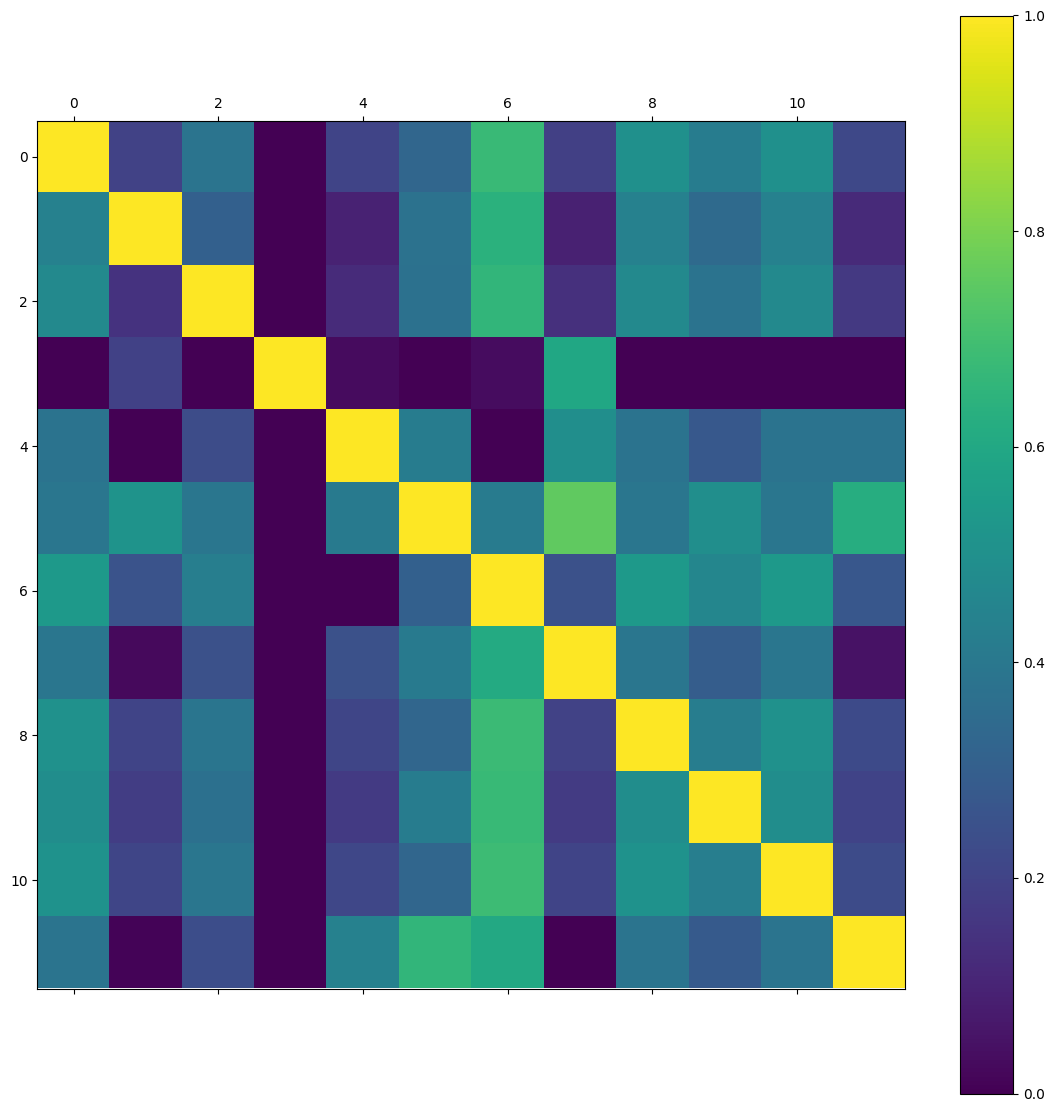

In [40]:
data = mi_matrix[:,:,1]

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

(12, 12)


/tmp/ipykernel_1394875/3908398069.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



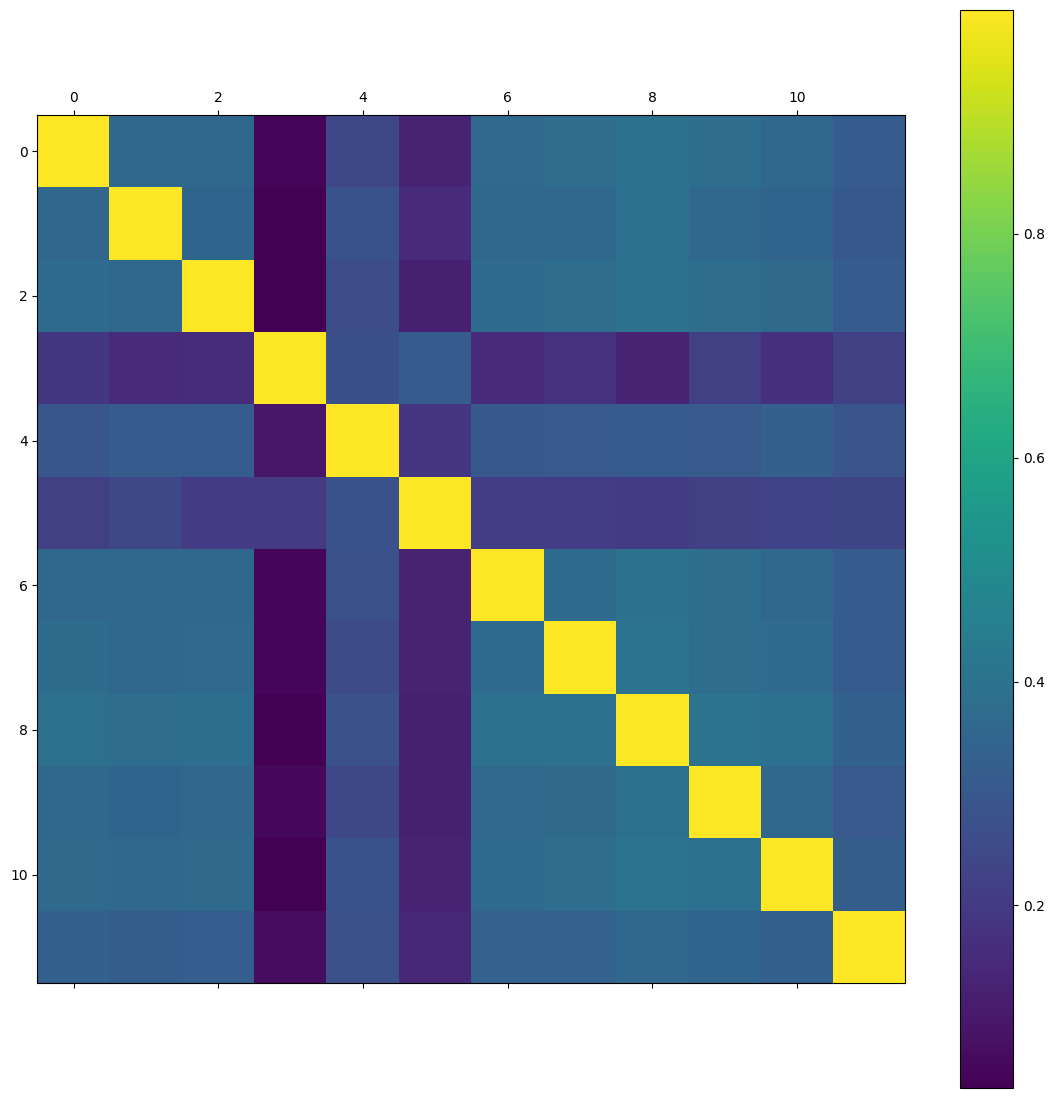

In [38]:
y = np.average(mi_matrix, axis=2)
# y[y>0.5] = 1
# y = np.where(y > 0.5, 1, 0)
print(y.shape)

# alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = y

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

# ax.set_xticks(np.arange(len(alpha)), labels=alpha)
# ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

In [5]:
mi_matrix.shape

(126, 126, 120)

In [14]:
matrices[matrix_sub[0]][:,0].shape

(149,)

In [39]:
import plotly.express as px

# z = [[.1, .3, .5, .7, .9],
#      [1, .8, .6, .4, .2],
#      [.2, 0, .5, .7, .9],
#      [.9, .8, .4, .2, 0],
#      [.3, .4, .5, .7, 1]]

fig = px.imshow(mi_matrix[:,:,0], x = matrix_sub, y = matrix_sub, text_auto=True)
fig.layout.height = 1000
fig.layout.width = 1000
fig.show()

In [21]:
uae_data["UAE"][100]

array([0.0742125 , 0.09468929, 0.09336582, 0.1012739 , 0.0709512 ,
       0.08138237, 0.05146821, 0.06534757, 0.04016871, 0.0515305 ,
       0.03029178, 0.07590509, 0.03437581, 0.08683096, 0.05199276,
       0.05381288, 0.0536583 , 0.0440031 , 0.05443942, 0.02891355,
       0.05092984, 0.04175028, 0.05107294, 0.02359117, 0.04632369,
       0.02302783, 0.04952048, 0.02427632, 0.04610355, 0.02211938,
       0.04324138, 0.02420023, 0.04293865, 0.01937974, 0.03879929,
       0.02045389, 0.03813133, 0.01725617, 0.06448865, 0.05151163,
       0.04187908, 0.04890484, 0.04257125, 0.04838363, 0.03478137,
       0.04619425, 0.05081202, 0.04407166, 0.03970751, 0.04066674,
       0.04304576, 0.04046412, 0.04083347, 0.04228806, 0.0435772 ,
       0.0397019 , 0.0582471 , 0.04233456, 0.03994317, 0.04031697,
       0.04693473, 0.03948602, 0.04291378, 0.03983498, 0.03883828,
       0.03832012, 0.03515916, 0.04118077, 0.03869746, 0.03997035,
       0.02946358, 0.04179857, 0.04929446, 0.03926365, 0.03336

In [22]:
img = plt.imread("/media/sarvagya-pc/2TB HDD/Balgrist/MPM_nonProcessed/axial/BSL-002_ses-01/img_132.png")

In [26]:
img.shape

(224, 176, 4)